# Lab Project 1
# Part 1: Pulse Acquisition and Detector Characterization


## Introduction
This Jupyter Notebook will provide you a starting point to interface with the data acquisition system (DAQ) you have already deployed from Vivado/Vitis into the ZedBoard. The DAQ analog frontend (AFE) is provided with a 50 Msps A/D converter (ADC) and a 50 Msps D/A converter (DAC).

In this stage of the project, the AFE will work as follows:
- The ADC digitizes the raw signal from the detector
- The DAC provides a signal loopback to assess the correctness of the digitalization and data representation within the FPGA fabric.

Before starting, you should have previously finished the following steps:

    [x] Deploying a trigger-based digitalization design (oscilloscope) using the ComBlock in the SoC PL (Vivado)
    [x] Executing the UDMA server firmware in the SoC PS (Vitis) 

## Goals
The main goal of this exercise (Lab Project Part 1) is:

    - Computing the parameters that better fit the behavior of the detector, based on the pulse model

To do so, the following secondary goals shall be achieved:  

    - Acquire and record a dataset of multiple raw pulses from the detector, using the SoC/FPGA DAQ via UDMA
    - Clean up the dataset to remove unwanted pulses and restore their baseline
    - Fit the recorded pulses to get the average parameters that better represent the ideal pulse model of the detector

## Procedure
You will have the opportunity to demonstrate the gained knowledge throughout the previous laboratory sessions. We will provide you some hints to guide you through the steps to achieve the goals; however, the instructions are limited, leaving you the chance to write the code from scratch with the help of a couple of high-abstraction level libraries.

You may use the guides from previous exercises as auxiliary material, especially the one from Lab 4. The recommended steps to follow are divided in two sections as follows:

### A) Data acquisition
- Connect to the ZedBoard via UDMA
- Disable the UDMA logging to speed up the data acquisition
- Setup initial acquisition parameters, using the ComBlock output registers
  - Threshold level to trigger the capture of a pulse
  - Number of samples to capture before the trigger
  - Total number of pulses to capture ($N$)
- Record $N$ pulses via UDMA using the _pulsefit_ library
  - Verify that the recorded dataset matches your expectations
  - Change the acquisition parameters and repeat the recording, if necessary

### B) Data analysis
#### B.1) Data wrangling
- Clean up (remove) the saturated pulses
- Restore the baseline of the remaining pulses
- Leave only high-energy pulses, to reduce the fitting uncertainty

#### B.2) Pulse fitting - detector characterization
- Fit each individual pulse in the dataset using the _pulsefit_ library
- Obtain the average parameter values that better represent the detector behavior:
  - `tauDecay` ($\tau_D$)
  - `tauRise` ($\tau_R$)
  - `timeArrival` ($t_0$)


---

- Author(s): Ivan Morales (MLab/ICTP) - 2023/11/20 (version 1.0)
- Update(s):

---

### Before starting

🔴 All the instructions that are intended for you to code from scratch will be shown as follows: 🔴
> Instruction to follow




Importing libraries and initializing the detector parameters. Do not change any value if you are not sure of what they mean.

In [97]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pulsefit import PulseFit
import udma
import time

# Total trace length (samples). This value must match the Vivado Block Design settings.
TRACE_LEN = 2048     # Number of samples to be recorded
SAMPLING_RATE = 50e6 # Sampling rate (fs) of the ADC (50 Msps)
ADC_RESOLUTION = 14  # Resolution of the ADC
DC_OFFSET = (2**ADC_RESOLUTION // 2)

## A) Data acquisition

### Pulse recording from detector

#### Connecting to ZedBoard via UDMA

> Connect to the ZedBoard at the designated IP address and port

In [98]:
IP_ADDRESS = '192.168.1.10' # Set your ZedBoard IP Address here
IP_PORT = 7

# Create the UDMA instance and then connect to the ZedBoard. Assign it to the variable called "zedBoard"
zedBoard = udma.UDMA_CLASS(IP_ADDRESS, IP_PORT)

In [99]:
connectionStatus = 0
while(connectionStatus == 0):
    connectionStatus = zedBoard.connect()
    time.sleep(1)

> Do not forget to disable the logging in UDMA to speed-up the transactions

In [100]:
# Disable unused logging to speed up data transactions
_ = zedBoard.log(0)

#### Setting up pulse acquisition parameters

The trigger logic block in the Vivado Block design acts as a simple oscilloscope. Set the parameter values that you'll use for the acquisition. These values can be changed according to your needs.

In [111]:
THRESHOLD_LEVEL = DC_OFFSET + 1000  # In ADC values (must ALWAYS include the DC offset)
SAMPLES_BEFORE_TRIGGER = 512        # Samples to be recorded before the trigger
TOTAL_PULSES_TO_RECORD = 100        # Number of pulses to be recorded

print(THRESHOLD_LEVEL)

10192


The following registers must match your Vivado design

Comblock Register Outputs -> TriggerLogic Block Inputs

> Write the ComBlock register outputs that match the TriggerLogic block inputs, according to your block design in Vivado

Use the constants from in the previous cell, defined with self-explanatory names:
- `THRESHOLD_LEVEL`
- `SAMPLES_BEFORE_TRIGGER`
- `TOTAL_PULSES_TO_RECORD`

🔴 Notice that `THRESHOLD_LEVEL` is defined with a DC_OFFSET that must be always present 🔴

In [102]:
# Use the constants defined in the previous code block (THRESHOLD_LEVEL, SAMPLES_BEFORE_TRIGGER, TOTAL_PULSES_TO_RECORD)
# Output registers
CB_TOTAL_PULSES_REG		= 0 # variable data a
CB_SAMPLES_REG		    = 1 # variable data b
CB_THRESHOLD_REG	    = 2 # operation code register

In [115]:
zedBoard.write_reg(reg = CB_TOTAL_PULSES_REG, data = TRACE_LEN)
zedBoard.write_reg(reg = CB_SAMPLES_REG, data = SAMPLES_BEFORE_TRIGGER)
zedBoard.write_reg(reg = CB_THRESHOLD_REG, data = THRESHOLD_LEVEL)

KeyboardInterrupt: 

#### Initializing pulse recording and fitting library

In [104]:
# Setting up recording and analysis parameters
pulseAnalysis = PulseFit(
    pulseLenSamples = TRACE_LEN,
    samplingRate = SAMPLING_RATE,
    resolutionBits = ADC_RESOLUTION
)

#### Recording dataset
The ```recordDataset``` method is a high-level function that executes several times (```TOTAL_PULSES_TO_RECORD```) the ```UDMA.read_fifo``` instruction. You are already familiar with this UDMA functionality from Lab 4, so we provide you a shortcut here.

Results will be recorded in the variable ```dataset```

In [108]:
dataset = pulseAnalysis.recordDataset(
    pulseCount = TOTAL_PULSES_TO_RECORD,
    udmaInstance = zedBoard
)

After several seconds, you can observe the recorded dataset into a dataframe.

Each row represents a recorded pulse, while each column is the sampled analog value from the ADC.

Consequently, the number of columns must match with the ```TRACE_LEN``` constant, and the number of rows must be equal to the ```TOTAL_PULSES_TO_RECORD``` value.

In [113]:
# Just printing the recorded dataset values
dataset

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,8132,8137,8142,8133,8130,8131,8135,8135,8127,8132,...,8121,8127,8128,8129,8127,8128,8134,8125,8126,8122
1,8133,8138,8133,8134,8140,8138,8138,8136,8139,8143,...,8132,8125,8132,8126,8126,8126,8128,8125,8126,8130
2,8134,8126,8143,8131,8137,8128,8140,8138,8135,8135,...,8125,8120,8122,8118,8122,8125,8122,8127,8122,8130
3,8127,8142,8136,8128,8133,8131,8134,8130,8137,8131,...,8133,8137,8134,8141,8134,8138,8135,8136,8135,8139
4,8140,8137,8135,8147,8141,8131,8141,8134,8130,8140,...,8130,8133,8136,8135,8138,8138,8135,8137,8136,8138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,8135,8132,8144,8136,8148,8140,8137,8140,8142,8138,...,8137,8139,8133,8144,8136,8142,8138,8143,8143,8135
96,8133,8131,8130,8133,8132,8133,8128,8135,8132,8133,...,8132,8142,8135,8137,8137,8129,8134,8133,8130,8133
97,8120,8122,8121,8127,8124,8125,8133,8126,8131,8127,...,8135,8132,8135,8136,8123,8134,8135,8127,8142,8134
98,8132,8134,8133,8136,8134,8136,8128,8137,8139,8142,...,8142,8136,8128,8132,8134,8134,8134,8141,8136,8139


A visual representation of the recorded dataset, previous to the cleaning process.

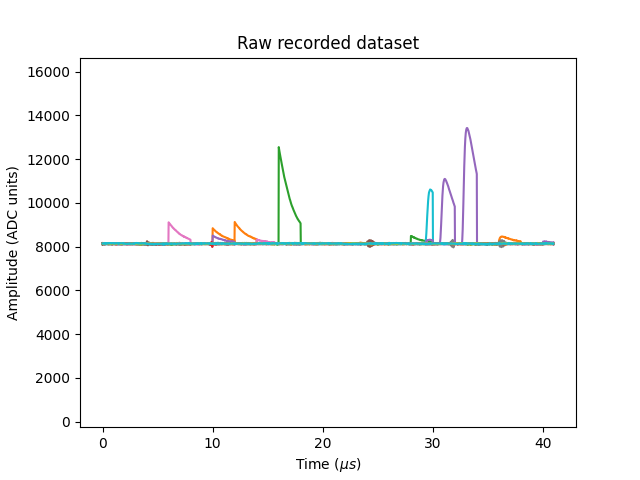

In [114]:
timeAxisMicroseconds = pulseAnalysis.getTimeAxisContinuous(useMicroSeconds = True)
timeAxisSeconds = pulseAnalysis.getTimeAxisContinuous(useMicroSeconds = False)
PLOT_Y_OFFSET = 256
plt.figure()
plt.plot(timeAxisMicroseconds, dataset.T.values)
plt.title("Raw recorded dataset")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude (ADC units)")
plt.ylim((-PLOT_Y_OFFSET, 2**ADC_RESOLUTION + PLOT_Y_OFFSET))

plt.show()

## B) Data analysis

### B.1) Data wrangling

#### Removing saturated pulses

The following steps will take the original dataset and remove the saturated pulses 

In [112]:
datasetNoSat = pulseAnalysis.removeSaturated(dataset)

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [ ]:
# Plotting the recorded dataset along the non-saturated dataset

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(timeAxisMicroseconds, dataset.T.values)
plt.title("Original recorded dataset")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude (ADC units)")
plt.ylim((-PLOT_Y_OFFSET, 2**ADC_RESOLUTION + PLOT_Y_OFFSET))

plt.subplot(1, 2, 2)
plt.title("Non-saturated pulses")
plt.plot(timeAxisMicroseconds, datasetNoSat.T.values)
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude (ADC units)")
plt.ylim((-PLOT_Y_OFFSET, 2**ADC_RESOLUTION + PLOT_Y_OFFSET))

plt.show()


#### Restoring baseline

Use the dataset without saturated events (`datasetNoSat`) to restore their baseline average to `0` adc units

In [ ]:
datasetNoSatNoBl = pulseAnalysis.restoreBaseline(datasetNoSat)

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.title("Pulses before baseline restoring")
plt.plot(timeAxisMicroseconds, datasetNoSat.T.values)
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude (ADC units)")
plt.ylim((-PLOT_Y_OFFSET, 2**ADC_RESOLUTION + PLOT_Y_OFFSET))

plt.subplot(1, 2, 2)
plt.plot(timeAxisMicroseconds, datasetNoSatNoBl.T.values)
plt.title("Pulses with restored baseline")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude (ADC units)")
plt.ylim((-200, 2**ADC_RESOLUTION + PLOT_Y_OFFSET))
plt.show()


#### Removing small pulses

This step is required to use the pulses that were recorded with the highest amplitude definition, leading to a lower fitting error.

Notice that the amount of pulses may be considerably reduced after this filtering process.

In [ ]:
# Define the minimum amplitude of the pulses to be used in the fitting process.
# Use the previous plot to inspect a reasonable limit.
amplitudeThreshold = 2048

In [ ]:
datasetFinal = pulseAnalysis.filterPulsesByAmplitude(datasetNoSatNoBl, threshold = amplitudeThreshold)
print(f"Final dataset pulse count: {len(datasetFinal)}")

#### Final dataset
Notice the difference of the original dataset, compared with the final version of it.
The following steps were carried out:
- Removed saturated pulses: their contribution to energy estimation is null, so they are removed
- Restored baseline: the average signal value before the pulse remains close to 0, so the pulse height can be reliably be determined
- Removed low-amplitude pulses: aiming to maximize the amplitude granularity of the pulses that will be further analyzed

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(timeAxisMicroseconds, dataset.T.values)
plt.title("Original recorded dataset")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude (ADC units)")
plt.ylim((-PLOT_Y_OFFSET, 2**ADC_RESOLUTION + PLOT_Y_OFFSET))

plt.subplot(1, 2, 2)
plt.plot(timeAxisMicroseconds, datasetFinal.T.values)
plt.title("Final (clean) dataset")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude (ADC units)")
plt.hlines(y = amplitudeThreshold, xmin = timeAxisMicroseconds[0], xmax = timeAxisMicroseconds[-1], linestyles='--', colors = 'gray')
plt.ylim((-PLOT_Y_OFFSET, 2**ADC_RESOLUTION + PLOT_Y_OFFSET))

plt.show()

### B.2) Pulse fitting - detector characterization

By visually inspecting the last plot (pulses from **final dataset**), define the estimated parameters (initial guess) for the fitting process. Carefully notice the time units in the plot: the parameters must be defined in **seconds**.

To define a ```variable``` with the 3.7x10^-9 value in Python, you may use the following format for scientific notation: 

```python
variable = 3.7e-9
```

> Define the estimated decay and rise time constants of the detector, as well as the time of arrrival of the pulses

In [ ]:
# Set the initial guesses, using second units (not microseconds)

estimatedTauD = 5e-6 # Define your own estimation of decay constant using visual inspection
estimatedTauR = 1e-6 # Set your estimation for pulse rise time constant using visual inspection
estimatedT0 = 5e-6 # Set the estimated time of arrival from the visual inspection of the plot

Execute the fitting process next

In [ ]:
fitParameters, fitRelativeErrors = pulseAnalysis.fitPulses(dataset = datasetFinal,
                                                   estimatedTauD = estimatedTauD,
                                                   estimatedTauR = estimatedTauR,
                                                   estimatedT0 = estimatedT0
                                                   )


#### Fitting results

These values represent the unique parameters of your detector. **Write them down**, since they will be useful in the next stage of the project.

In [ ]:
# Printing out the parameter fitting results
fitParameters

Relative errors are useful to determine whether the fitting was successful or not. If these values are too high (e.g. larger than **0.05**, or **5%**), you may repeat the fitting process with other initial guesses.

In case either `inf` or `-inf` values appear, your initial estimations were too far away for the experimental data used for fitting. Please repeat the fitting process by carefully setting the initial parameters (`estimatedTauD`, `estimatedTauR`, `estimatedT0`).

In [ ]:
# Printing out the parameter fitting relative errors
fitRelativeErrors

#### Visual inspection of fitting result

Plotting the "ideal" pulse shape using the fitted parameters, along with an experimental pulse you have just recorded: they should visually match. 

This is another way to easily get a hint of the fitting results. Notice that experimental data will always contain noise that may be visible.

In [ ]:
# Using the 'fitParameters' that contains the fitting results
idealPulse = pulseAnalysis.pulseModel(t = timeAxisSeconds,
                                      A = 1,
                                      tauD = fitParameters['fit_tauDecay'],
                                      tauR = fitParameters['fit_tauRise'],
                                      t0 = fitParameters['fit_tArrival_t0'])

# Normalizing amplitude
idealPulse /= np.max(idealPulse)


In [ ]:
# Choosing a random pulse from the recorded dataset
experimentalPulse = datasetFinal.sample().T.values

# Normalizing amplitude
experimentalPulse = experimentalPulse/np.max(experimentalPulse)


In [ ]:
plt.figure()
plt.plot(timeAxisMicroseconds, idealPulse, '-', linewidth = 3)
plt.plot(timeAxisMicroseconds, experimentalPulse, '--')
plt.title("Pulse shape comparison")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude (ADC units)")
plt.legend(["Fitted (ideal) pulse", "Experimental data"])

plt.show()